# Digital Signal Processing

### MsCV - ViBOT - MAIA

In [1]:
%matplotlib inline
%pprint off

# To make some nice plot
import matplotlib.pyplot as plt
# To play with arrays
import numpy as np
import scipy as sp
from skimage import io

from skimage import color
from skimage import img_as_float
from matplotlib import cm
from scipy.stats import norm
from skimage import exposure
from skimage import filters
from skimage.filters import rank
from skimage import transform
from skimage import img_as_ubyte

from scipy import signal
from scipy.io import wavfile
from scipy import fftpack



/home/hassan/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Pretty printing has been turned OFF


## 2D - Discrete Fourier Transform
**1.1** Consider a syntetic image as following:

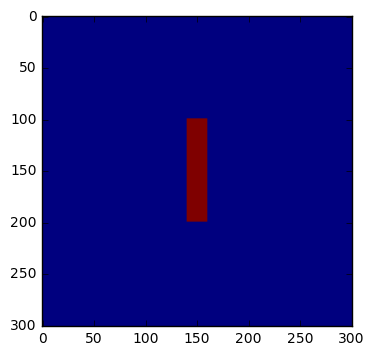

In [2]:
# Create a synthetic image
img = np.zeros((301,301))
# Draw a rectangle inside
img[100:200, 140:160] = 255

plt.figure()
plt.imshow(img)

**1.2** We can compute the FFT as follows:

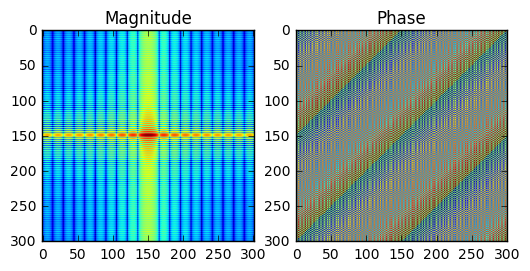

In [3]:
# Compute the DFT
img_freq = np.fft.fftshift(np.fft.fft2(img))

# We can show the magnitude and the phase
# Two subplots, the axes array is 1-d
f, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(exposure.adjust_log(np.abs(img_freq)))
ax1.set_title('Magnitude')
ax2.imshow(np.angle(img_freq))
ax2.set_title('Phase')


**1.3** Compute the FFT of translated, rotated and other verisons of the synthetic image and illustrate the magnitude and phase of the frequency response. 

Discuss your observations

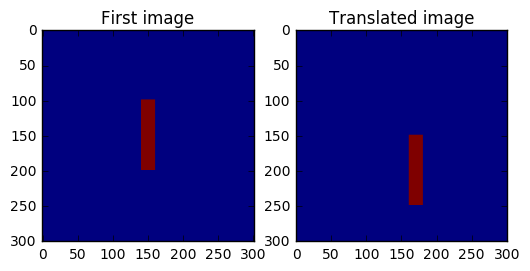

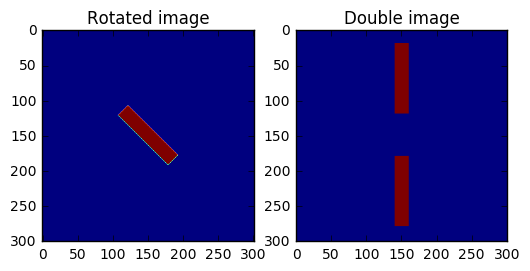

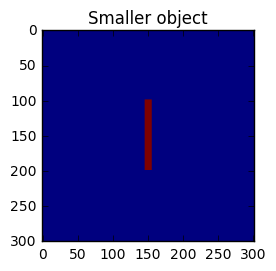

In [4]:
# Create a synthetic image
img = np.zeros((301,301))
# Draw a rectangle inside
img[100:200, 140:160] = 255

# Create a synthetic image
img_trans = np.zeros((301,301))
# Draw a rectangle inside
img_trans[150:250, 160:180] = 255

img_rot = transform.rotate(img, 45)

# Create a synthetic image
img2 = np.zeros((301,301))
# Draw a rectangle inside
img2[20:120, 140:160] = 255
img2[180:280, 140:160] = 255


# Create a synthetic image
img3 = np.zeros((301,301))
# Draw a rectangle inside
img3[100:200, 145:155] = 255

plt.figure
plt.subplot(121)
plt.imshow(img)
plt.title('First image')

plt.subplot(122)
plt.imshow(img_trans)
plt.title('Translated image')
plt.show()

plt.figure()
plt.subplot(121)
plt.imshow(img_rot)
plt.title('Rotated image')

plt.subplot(122)
plt.imshow(img2)
plt.title('Double image')
plt.show()

plt.figure
plt.subplot(121)
plt.imshow(img3)
plt.title('Smaller object')
plt.show()


**1.4** Lets consider another synthetic image as follows, compute the phase and the magnitude of the followig image and display the normalized center frequency 

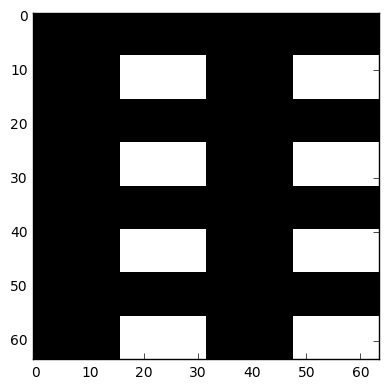

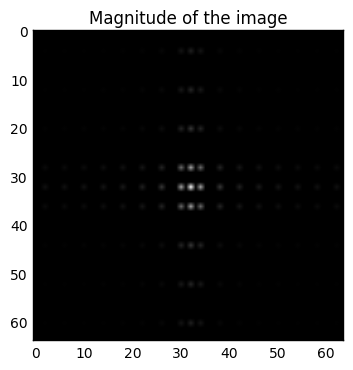

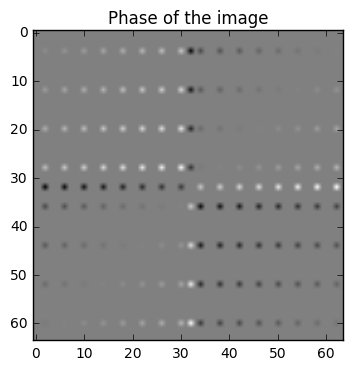

Center frequency is 0.25


In [7]:
N = 64
Img = np.zeros((N,N))
# Length of the signal
T = 1. 
# Sampling period 
Ts = T/N 
Fs = 1./Ts
df = Fs/N
tem = np.ones((8,16))
Img[N/8:N/4, N/4:N/2] = tem 
Img[0:N/4,N/2:] = Img[0:N/4, :N/2]
Img[N/4:N/2,:] = Img[0:N/4 ,:]
Img[N/2:,:] = Img[0:N/2,:]

plt.figure
io.imshow(Img)
plt.show()

# Normalize fft2
Img_freq = np.fft.fft2(Img)
Img_freq = Img_freq/N**2
Img_freq= np.fft.fftshift(Img_freq);


plt.figure
plt.imshow(np.abs(Img_freq), cmap = cm.gray)
plt.title('Magnitude of the image')
plt.show()

plt.figure
plt.imshow(np.angle(Img_freq), cmap = cm.gray)
plt.title('Phase of the image')
plt.show()

print 'Center frequency is {}'.format(np.abs(Img_freq[N/2, N/2]))

**1.5** Plot $|I_{f}(u,0)|$ and $|I_{f}(0,v)|$ with the corrrect frequency range. 

Discuss your observations.


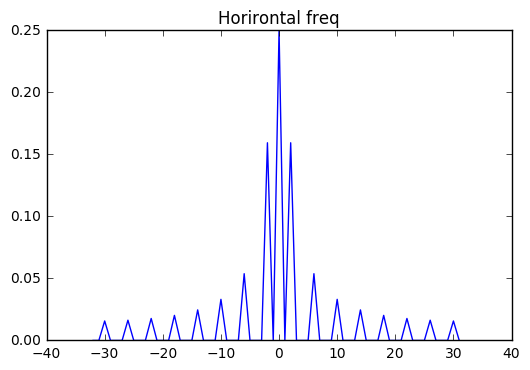

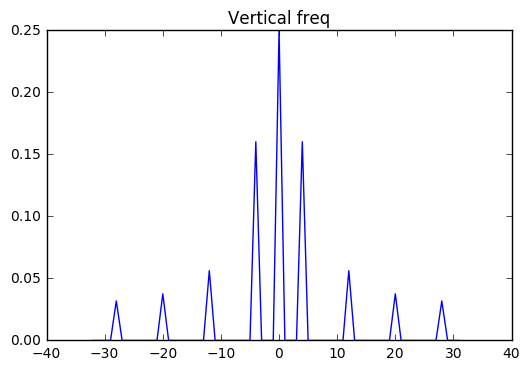

In [8]:
hsf = 0
vsf = 0
# Horizontal frequency axis
hsf = Img_freq[N/2,:]
t = np.arange(-N/2, N/2, 1)
plt.figure
plt.plot(t, np.abs(hsf))
plt.title('Horirontal freq')
plt.show()

# Vertical frequency axis
vsf = Img_freq[:,N/2]
plt.figure
plt.plot(t, np.abs(vsf))
plt.title('Vertical freq')
plt.show()

**1.6** Load the `lena` image, and show its phase and its magnitude, then reconstruct the image using either frequency or phase. 

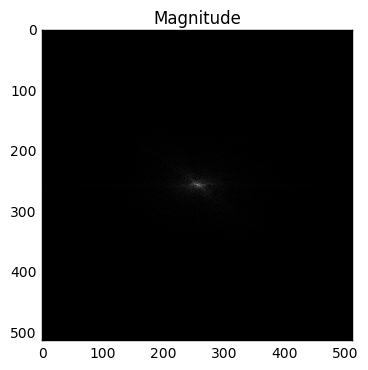

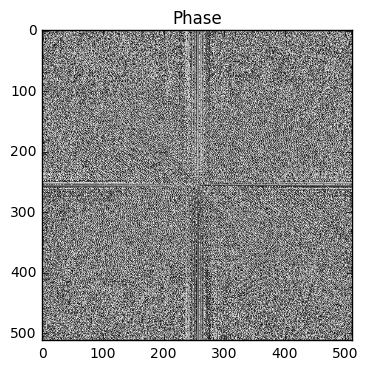

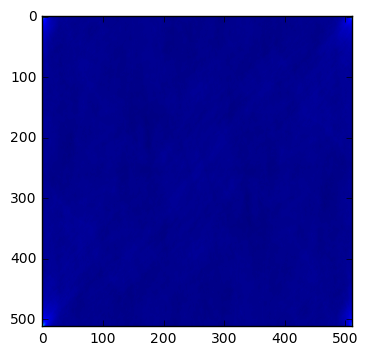

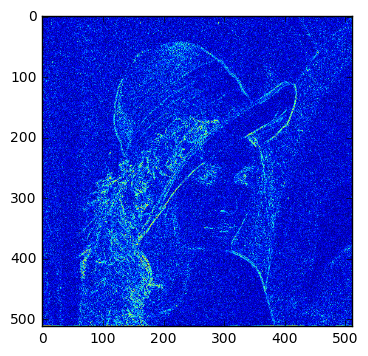

In [12]:

img = io.imread('../images/lena-grey.bmp')

img = img_as_ubyte(img)

[row, col] = img.shape
img_freq = np.fft.fft2(img)
img_freq = img_freq/(row*col)
img_freq = np.fft.fftshift(img_freq)
Mag_freq = np.abs(img_freq)
Phase_freq = np.angle(img_freq)

plt.figure
plt.imshow(exposure.adjust_log(Mag_freq), cmap = cm.gray)
plt.title('Magnitude')
plt.show()

plt.figure
plt.imshow(Phase_freq, cmap = cm.gray)
plt.title('Phase')
plt.show()


# Compute the image back with no phase
img_no_phase = np.abs(np.fft.ifft2(Mag_freq))
plt.figure()
plt.imshow(exposure.adjust_log(np.abs(img_no_phase)))
plt.show()

# Compute the image back with no phase
Mag_freq[:, :] = 150
img_no_mag = np.abs(np.fft.ifft2(Mag_freq*np.exp(1j*Phase_freq )))
plt.figure()
plt.imshow(exposure.adjust_log(np.abs(img_no_mag)))
plt.show()



**1.7** Apply the sobel filter only in vertical direction to `lena` image in the frequency domain.

### Filtering in Frequency domain 

In order to build a frequency filter $H(u,v)$ from its spatial counterpart $h(x,y)$, we need to:

1. Build a zero padded spatial filter $h_p(x,y)$
1. Shift $h_p(x,y)$ by $(-1)^{x+y}$
1. Compute the DFT to obtain $H(u,v)$
1. Shift $H(u,v)$ by $(-1)^{x+y}$

In order to aboid the wraparound error, the image need to be zero padded

In order to perform the filtering, we need to:

1. Find the padded image size
1. Pad the image
1. Convert the spatial filter to frequency filter
1. Compute the DFT of the image with additional shift
1. Apply the multiplication in the Fourier space
1. Compute the inverse Fourier transform
1. Crop the image at its original size

In [13]:
def build_frequency_filter(h, sz_h_p):
    ###--- 1. Build a zero padded spatial filter $h_p(x,y)$ ---###
    # Create the zero padded spatial filter
    h_p = np.zeros(sz_h_p)
    # Find the center of the zero padded
    ctr_h_p = np.divide(sz_h_p, 2)
    # Assign the original filter
    h_p[ctr_h_p[0]:ctr_h_p[0] + np.size(h, 0),
        ctr_h_p[1]:ctr_h_p[1] + np.size(h, 1)] = h
    
    ###--- 2. Shift $h_p(x,y)$ by $(-1)^{x+y}$ ---###
    h_p_shifted = np.fft.fftshift(h_p)
    
    ###--- 3. Compute the DFT ---###
    H = np.fft.fft2(h_p_shifted)
    
    ###--- 4. Shift $H_p(u,v)$ by $(-1)^{x+y}$ ---###
    H_shifted = np.fft.fftshift(H)
    
    return H_shifted

def find_padding_size(img, h):
    # Get the size of the patch
    h_sz = h.shape
    img_sz = img.shape
    
    # Compute the future size
    height_pad = h_sz[0] + img_sz[0] - 1
    width_pad = h_sz[1] + img_sz[1] - 1
    
    if not (np.mod(height_pad, 2) == 1):
        height_pad = height_pad + 1
    if not (np.mod(width_pad, 2) == 1):
        width_pad = width_pad + 1
        
    future_size = (height_pad, width_pad)
        
    return future_size

def img_padding(img, sz_img):
    # Initialise and pad the image with zero
    img_p = np.zeros(sz_img)
    img_p[0:np.size(img, 0), 0:np.size(img, 1)] = img
    
    return img_p


def filtering_freq(img, filt_sp, verbose=True):
    
    ###--- 1. Find the size of the padded image ---#
    sz_img = find_padding_size(img, filt_sp)
    
    ###--- 2. Pad the image ---###
    img_p = img_padding(img, sz_img)
    if (verbose):
        plt.figure()
        io.imshow(img_p)
    
    ###--- 3. Compute the frequency filter ---###
    filter_freq = build_frequency_filter(filt_sp, sz_img)
    # We can keep only the imaginary part of the filter
    filter_freq = np.zeros(sz_img) + 1j * np.imag(filter_freq)
    if (verbose):
        plt.figure()
        io.imshow(exposure.adjust_log(np.abs(filter_freq)))
    
    ###--- 4. Compute the DFT of the image with additional shift ---###
    img_freq = np.fft.fftshift(np.fft.fft2(img_p))
    if (verbose):
        plt.figure()
        io.imshow(exposure.adjust_log(np.abs(img_freq)))
    
    ###--- 5. Apply the multiplication in the Fourier space ---###
    img_filt_freq = img_freq * filter_freq
    if (verbose):
        plt.figure()
        io.imshow(exposure.adjust_log(np.abs(img_filt_freq)))
    
    ###--- 6. Compute the inverse Fourier transform ---###
    img_filt_sp_p = np.fft.ifft2(np.fft.fftshift(img_filt_freq))
    
    ###--- 7. Crop the image at its original size ---###
    return img_filt_sp_p[0:img.shape[0], 0:img.shape[1]]

/home/hassan/anaconda2/lib/python2.7/site-packages/skimage/io/_plugins/matplotlib_plugin.py:77: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  warn("Float image out of standard range; displaying "


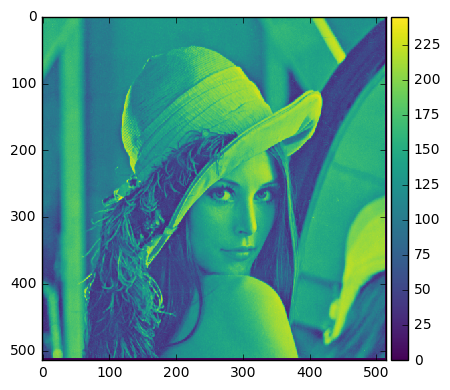

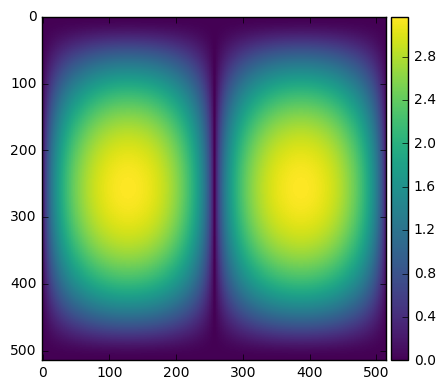

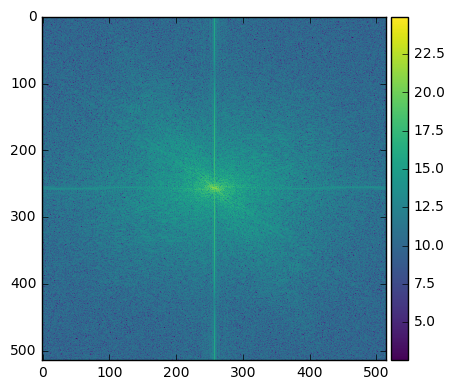

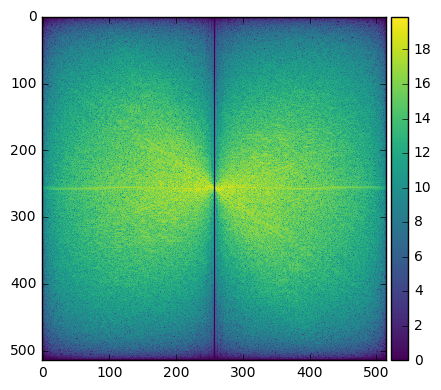

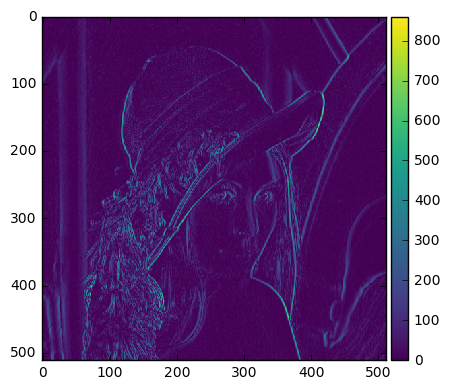

/home/hassan/anaconda2/lib/python2.7/site-packages/skimage/io/_plugins/matplotlib_plugin.py:74: UserWarning: Low image dynamic range; displaying image with stretched contrast.
  warn("Low image dynamic range; displaying image with "


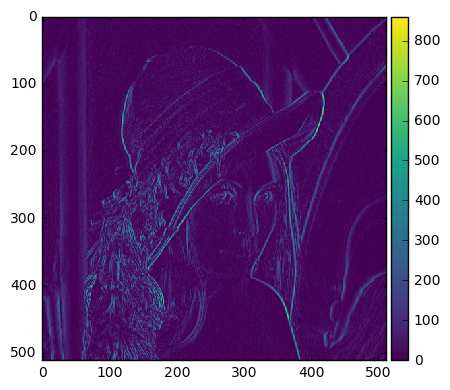

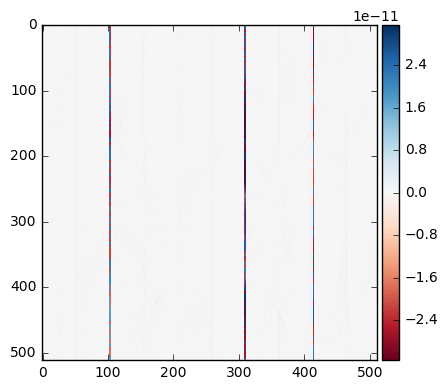

In [14]:
sobel_y_spat = np.array([[-1,-2,-1],[0,0,0],[1,2,1]]).T

result_img = filtering_freq(img, sobel_y_spat)

plt.figure()
io.imshow(np.abs(result_img))
plt.show()

from scipy.signal import convolve2d
result_img2 = convolve2d(img, sobel_y_spat, 'same')

plt.figure()
io.imshow(np.abs(result_img2))
plt.show()

plt.figure()
io.imshow(np.abs(result_img) - np.abs(result_img2))
plt.show()
